In [27]:
import os
import tqdm
import numpy as np

import torch
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1
%aimport utils_data
%aimport utils_model
%aimport utils_attack

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

# Datasets and dataloaders preparation 

In [3]:
(train_set_10, test_set_10), (train_loader_10, test_loader_10) = utils_data.get_train_test_dataloaders(
    dataset_type='cifar10', 
    root_data_folder='./data', 
    batch_size=64
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
(train_set_100, test_set_100), (train_loader_100, test_loader_100) = utils_data.get_train_test_dataloaders(
    dataset_type='cifar100', 
    root_data_folder='./data', 
    batch_size=64
)

Files already downloaded and verified
Files already downloaded and verified


# Model

## Loading and fine-tuning ResNet50 pretrained on ImageNet 
**(you can skip this part if you already have a model pretrained on CIFAR10/100)**

In [5]:
model_10 = torchvision.models.resnet50(pretrained=True)
model_10.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model_10 = model_10.to(device)
model_10

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
model_100 = torchvision.models.resnet50(pretrained=True)
model_100.fc = nn.Linear(in_features=2048, out_features=100, bias=True)
model_100 = model_100.to(device)
model_100

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
utils_data.set_random_seeds(seed_value=123, device=device)
criterion = nn.CrossEntropyLoss()

'''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
optimizer_10 = optim.SGD(model_10.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)
scheduler_10 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_10, T_max=200)

NameError: name 'model' is not defined

In [6]:
utils_data.set_random_seeds(seed_value=123, device=device)
criterion = nn.CrossEntropyLoss()

optimizer_100 = optim.SGD(model_100.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)
scheduler_100 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_100, T_max=200)

In [7]:
model_10 = utils_model.train(train_loader_10, test_loader_10, model_10, criterion, optimizer_10, scheduler_10, n_epochs=10, device=device)

 10%|█         | 1/10 [01:01<09:13, 61.49s/it]

[Epoch 1] train loss: 1.108; train acc: 0.61; test loss: 0.736; test acc: 0.74


 20%|██        | 2/10 [01:58<07:51, 58.97s/it]

[Epoch 2] train loss: 0.700; train acc: 0.76; test loss: 0.577; test acc: 0.80


 50%|█████     | 5/10 [04:47<04:44, 56.86s/it]

[Epoch 5] train loss: 0.460; train acc: 0.84; test loss: 0.462; test acc: 0.84


 60%|██████    | 6/10 [05:44<03:47, 56.93s/it]

[Epoch 6] train loss: 0.426; train acc: 0.85; test loss: 0.442; test acc: 0.85


 70%|███████   | 7/10 [06:42<02:51, 57.30s/it]

[Epoch 7] train loss: 0.386; train acc: 0.87; test loss: 0.416; test acc: 0.86


 80%|████████  | 8/10 [07:33<01:50, 55.13s/it]

[Epoch 8] train loss: 0.360; train acc: 0.87; test loss: 0.413; test acc: 0.86


 90%|█████████ | 9/10 [08:34<00:56, 56.97s/it]

[Epoch 9] train loss: 0.335; train acc: 0.88; test loss: 0.413; test acc: 0.86


  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 10] train loss: 0.317; train acc: 0.89; test loss: 0.409; test acc: 0.86


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered

In [7]:
model_100 = utils_model.train(train_loader_100, test_loader_100, model_100, criterion, optimizer_100, scheduler_100, n_epochs=10, device=device)

 10%|█         | 1/10 [00:58<08:44, 58.31s/it]

[Epoch 1] train loss: 3.135; train acc: 0.25; test loss: 2.161; test acc: 0.42


 20%|██        | 2/10 [01:56<07:47, 58.44s/it]

[Epoch 2] train loss: 2.054; train acc: 0.45; test loss: 1.761; test acc: 0.52


 30%|███       | 3/10 [02:55<06:48, 58.38s/it]

[Epoch 3] train loss: 1.726; train acc: 0.52; test loss: 1.621; test acc: 0.55


 40%|████      | 4/10 [03:54<05:51, 58.58s/it]

[Epoch 4] train loss: 1.541; train acc: 0.57; test loss: 1.522; test acc: 0.57


 50%|█████     | 5/10 [04:52<04:53, 58.65s/it]

[Epoch 5] train loss: 1.402; train acc: 0.60; test loss: 1.477; test acc: 0.58


 60%|██████    | 6/10 [05:51<03:54, 58.52s/it]

[Epoch 6] train loss: 1.295; train acc: 0.63; test loss: 1.424; test acc: 0.60


 70%|███████   | 7/10 [06:50<02:56, 58.95s/it]

[Epoch 7] train loss: 1.202; train acc: 0.65; test loss: 1.428; test acc: 0.60


 80%|████████  | 8/10 [07:55<02:01, 60.60s/it]

[Epoch 8] train loss: 1.113; train acc: 0.67; test loss: 1.411; test acc: 0.61


 90%|█████████ | 9/10 [08:56<01:01, 61.01s/it]

[Epoch 9] train loss: 1.043; train acc: 0.70; test loss: 1.385; test acc: 0.62


100%|██████████| 10/10 [09:59<00:00, 60.00s/it]

[Epoch 10] train loss: 0.969; train acc: 0.71; test loss: 1.393; test acc: 0.62


In [ ]:
path_to_model_save = './models'
torch.save(model_10.state_dict(), os.path.join(path_to_model_save, 'cifar10.pt'))

In [9]:
path_to_model_save = './models'
torch.save(model_100.state_dict(), os.path.join(path_to_model_save, 'cifar100.pt'))

## Load a model pretrained on CIFAR10/100
**to load pretrained model uncomment the cell below**

In [10]:
path_to_model_save = './models'
model_10 = torchvision.models.resnet50(pretrained=True)
model_10.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model_10.load_state_dict(
    torch.load(
        os.path.join(path_to_model_save, 'cifar10.pt')
    )
)
model_10 = model_10.to(device)

In [11]:
path_to_model_save = './models'
model_100 = torchvision.models.resnet50(pretrained=True)
model_100.fc = nn.Linear(in_features=2048, out_features=100, bias=True)
model_100.load_state_dict(
    torch.load(
        os.path.join(path_to_model_save, 'cifar100.pt')
    )
)
model_100 = model_100.to(device)

In [ ]:
# utils_data.set_random_seeds(seed_value=123, device=device)

# '''source https://github.com/kuangliu/pytorch-cifar/blob/master/main.py'''
# optimizer = optim.SGD(model.parameters(), lr=1e-3,
#                       momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# criterion = nn.CrossEntropyLoss()

# FGSM attack

In [12]:
results_df_10 = utils_attack.test_robustness_simple(
    model_10,
    test_loader_10,
    criterion,
    (1e-3, 1e0, 20), # (1e-3, 1e0, 20),
    attack_type="fgsm",
    n_samples_ret=5,
    device=device
)
results_df_10

100%|██████████| 20/20 [05:28<00:00, 16.41s/it]


Metric,Accuracy
Noise sigma,
0.001000,0.8503
0.001438,0.8448
0.002069,0.8342
0.002976,0.8190
0.004281,0.7963
0.006158,0.7663
0.008859,0.7209
0.012743,0.6589
0.018330,0.5822


In [13]:
results_df_100 = utils_attack.test_robustness_simple(
    model_100,
    test_loader_100,
    criterion,
    (1e-3, 1e0, 20), # (1e-3, 1e0, 20),
    attack_type="fgsm",
    n_samples_ret=5,
    device=device
)
results_df_100

100%|██████████| 20/20 [05:13<00:00, 15.67s/it]


Metric,Accuracy
Noise sigma,
0.001000,0.5991
0.001438,0.5906
0.002069,0.5747
0.002976,0.5540
0.004281,0.5284
0.006158,0.4914
0.008859,0.4446
0.012743,0.3907
0.018330,0.3285


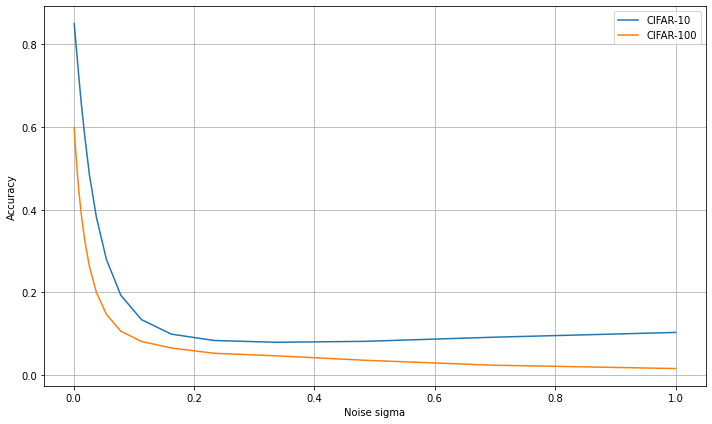

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(results_df_10.index, results_df_10['Accuracy'], label='CIFAR-10')
ax.plot(results_df_100.index, results_df_100['Accuracy'], label='CIFAR-100')
ax.set_xlabel('Noise sigma')
ax.set_ylabel('Accuracy')
ax.grid(visible=True)
ax.legend()

plt.tight_layout()
plt.show()

In [23]:
all_preds_10, all_preds_100 = torch.tensor([], device=device), torch.tensor([], device=device)
all_labels_10, all_labels_100 =  torch.tensor([], device=device), torch.tensor([], device=device)
# for images, labels in tqdm(test_loader_10):
for images, labels in test_loader_10:
    images, labels = images.to(device), labels.to(device)
    pred_10 = model_10(images)
    all_preds_10 = torch.cat([all_preds_10, pred_10.argmax(axis=1)])
    all_labels_10 = torch.cat([all_labels_10, labels])
    
# for images, labels in tqdm(test_loader_100):
for images, labels in test_loader_100:
    images, labels = images.to(device), labels.to(device)
    pred_100 = model_100(images)
    all_preds_100 = torch.cat([all_preds_100, pred_100.argmax(axis=1)])
    all_labels_100 = torch.cat([all_labels_100, labels])
    
acc_10 = accuracy_score(all_labels_10.detach().cpu().numpy(), all_preds_10.detach().cpu().numpy())
acc_100 = accuracy_score(all_labels_100.detach().cpu().numpy(), all_preds_100.detach().cpu().numpy())
acc_10, acc_100

(0.8653, 0.6225)

In [24]:
all_preds_10_np = all_preds_10.detach().cpu().numpy()
all_preds_100_np = all_preds_100.detach().cpu().numpy()

In [25]:
preds_class_change_10, radii_class_change_10 = utils_attack.get_adversarial_radii(
    model_10,
    all_preds_10_np,
    dataloader=test_loader_10,
    loss=criterion,
    num_samples=10000,
    min_v=1e-4,
    max_v=1000,
    step_v=2 ** 0.5,
    method="fgsm",
    device=device,
)

preds_class_change_100, radii_class_change_100 = utils_attack.get_adversarial_radii(
    model_100,
    all_preds_100_np,
    dataloader=test_loader_100,
    loss=criterion,
    num_samples=10000,
    min_v=1e-4,
    max_v=1000,
    step_v=2 ** 0.5,
    method="fgsm",
    device=device,
)

100%|██████████| 47/47 [12:11<00:00, 15.57s/it]


In [ ]:
# finite_radii_class_change_mask.shape, radii_inv_class_change.shape, finite_radii_class_change_mask.sum()

In [28]:
radii_inv_class_change_10, radii_inv_class_change_100 = -radii_class_change_10, -radii_class_change_100
finite_radii_class_change_mask_10, finite_radii_class_change_mask_100 = radii_inv_class_change_10 != -np.inf, radii_inv_class_change_100 != -np.inf
radii_inv_class_change_finite_10, radii_inv_class_change_finite_100 = radii_inv_class_change_10[finite_radii_class_change_mask_10], radii_inv_class_change_100[finite_radii_class_change_mask_100]
preds_class_change_10, preds_class_change_100 = all_preds_10_np[finite_radii_class_change_mask_10], all_preds_100_np[finite_radii_class_change_mask_100]

In [29]:
radii_class_change_finite_10, radii_class_change_finite_100 = radii_class_change_10[finite_radii_class_change_mask_10], radii_class_change_100[finite_radii_class_change_mask_100]

In [30]:
finite_radii_class_change_mask_10.mean(), finite_radii_class_change_mask_100.mean()

(0.9999, 1.0)

In [31]:
min_eps = 1e-4
max_eps = 1e3
step_eps = 2 ** 0.5
num_eps = int((np.log10(max_eps) - np.log10(min_eps)) / np.log10(step_eps)) + 1
bins = list(np.geomspace(min_eps, max_eps, num_eps))

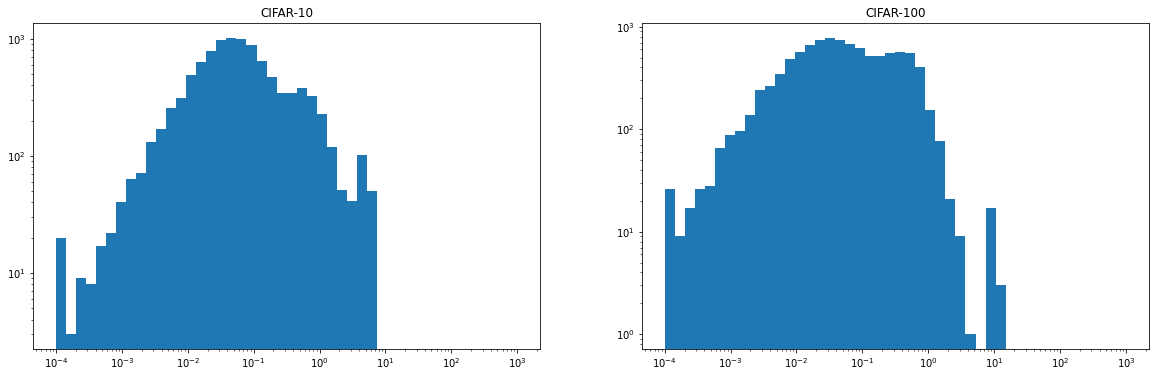

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax[0].hist(radii_class_change_finite_10, bins=bins);
ax[0].set_title('CIFAR-10')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].hist(radii_class_change_finite_100, bins=bins);
ax[1].set_title('CIFAR-100')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [33]:
from functools import partial

def get_radii_preds_func(radii, preds):
    return preds, radii

get_radii_inv_partial_class_change_10 = partial(get_radii_preds_func, radii_inv_class_change_10)
get_radii_inv_partial_class_change_100 = partial(get_radii_preds_func, radii_inv_class_change_100)

In [34]:
rejection_rates = np.linspace(0, 1.0, 20)

radii_accs_class_change_10 = utils_attack.reject_by_metric(
    get_radii_inv_partial_class_change_10,
    all_preds_10_np,
    all_labels_10.detach().cpu().numpy(),
    rejection_rates,
    accuracy_score
)
radii_accs_class_change_100 = utils_attack.reject_by_metric(
    get_radii_inv_partial_class_change_100,
    all_preds_100_np,
    all_labels_100.detach().cpu().numpy(),
    rejection_rates,
    accuracy_score
)

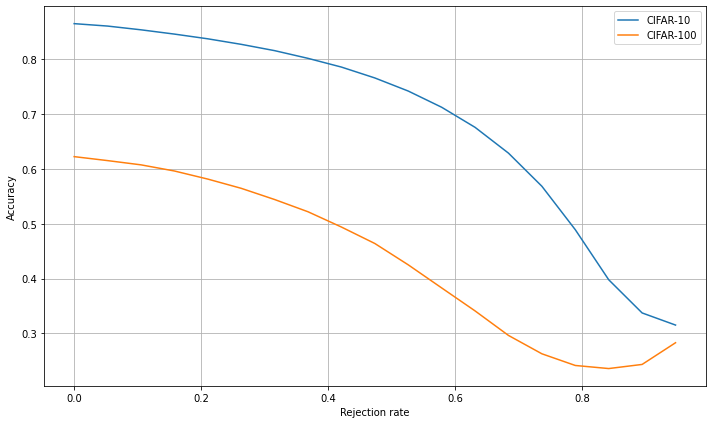

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

perf_metrics = [radii_accs_class_change_10, radii_accs_class_change_100]
line_labels = ['CIFAR-10', 'CIFAR-100']

for metric, label in zip(perf_metrics, line_labels):
    ax.plot(rejection_rates[0:len(metric)], metric, label=label)
ax.set_xlabel('Rejection rate')
ax.set_ylabel('Accuracy')
ax.grid(visible=True)
ax.legend()

plt.tight_layout()
plt.show()